In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM,Dense, Input, Embedding, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2024-06-05 16:58:20.072982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# loading the training data
train = pd.read_csv('train.csv')


In [5]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
# Reading word embeddings from a GloVe file and storing them in a dictionary called 'embedding_index'
embedding_index={}
f = open(r"glove.6B.100d.txt", encoding='utf-8')
for line in f:
  values=line.split()
  word = values[0]
  wts = np.asarray(values[-100:],dtype='float32')
  embedding_index[word]=wts
f.close()

In [8]:
# To get word vectors from the GloVe file associated with the word:'today'
embedding_index['today']

array([-0.19939  ,  0.37846  ,  0.52093  ,  0.28347  , -0.1898   ,
       -0.20947  , -0.23286  ,  0.14185  , -0.034916 , -0.36006  ,
       -0.0046717, -0.25207  ,  0.31364  , -0.34879  ,  0.032268 ,
       -0.45078  ,  0.011292 ,  0.090903 , -0.62866  ,  0.0079579,
        0.28065  ,  0.34158  , -0.25593  ,  0.11521  ,  0.10571  ,
       -0.45827  ,  0.32193  , -0.29186  ,  0.11443  ,  0.17972  ,
       -0.31633  ,  0.40085  , -0.24405  , -0.050205 ,  0.16485  ,
        0.5001   ,  0.11756  ,  0.043875 , -0.060235 , -0.66571  ,
       -0.40628  , -0.21691  ,  0.068156 , -0.38058  , -0.4512   ,
       -0.26966  ,  0.45961  , -0.23446  , -0.26416  , -1.1617   ,
        0.18417  , -0.53088  ,  0.54179  ,  0.78295  , -0.54864  ,
       -2.0634   , -0.63427  ,  0.095073 ,  1.9649   ,  0.47031  ,
       -0.54401  ,  0.73015  , -0.34352  , -0.43033  ,  0.27555  ,
        0.025185 ,  0.35053  ,  0.46295  ,  0.40837  , -0.011836 ,
        0.34553  , -0.17297  , -0.13765  , -0.23182  ,  0.3898

In [11]:
from sklearn.model_selection import train_test_split
Train_train, Test_test=train_test_split(train, test_size=0.25)

In [13]:
x_train=Train_train['question_text']
y_train=Train_train['target']
x_test=Test_test['question_text']
y_test=Test_test['target']

In [15]:
# Adds a new column to dataframe 'train' with the name:'length'
train['length']=[len(x) for x in train['question_text']]

In [17]:
# To get the maximum and minimum values in the 'length' column of the DataFrame train
train['length'].max(),train['length'].min()

(294, 7)

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


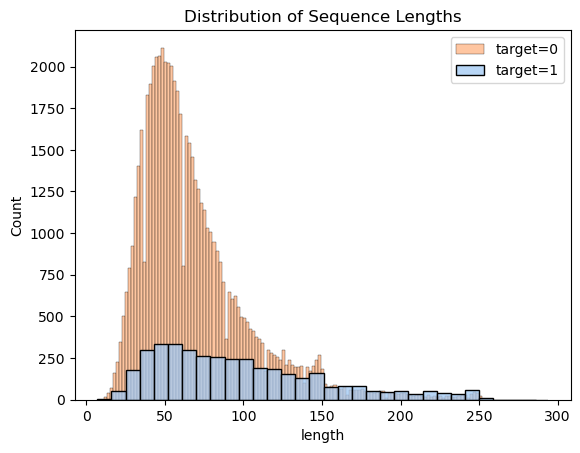

In [19]:
# Create a histogram of the distribution of sequence lengths in the train DataFrame, with separate histograms for rows where the 'target' column is equal to 0 and 1
sns.histplot(train.loc[train['target'] == 0, 'length'], kde=False, label='target=0', color=sns.color_palette('pastel')[1])
sns.histplot(train.loc[train['target'] == 1, 'length'], kde=False, label='target=1', color=sns.color_palette('pastel')[0])
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [21]:
max_len=251
# To create a Tokenizer object named 'Tk' for tokenizing text data.
Tk=Tokenizer(char_level=False,split=' ')
# Tokenizer learns the vocabulary and tokenizes the text in x_train
Tk.fit_on_texts(x_train)

In [23]:
# To calculate the number of unique words (or tokens) in your text data, which is the vocabulary size of the tokenizer('Tk')
vocab_size=len(Tk.word_index)

In [25]:
vocab_size

37348

In [27]:
# To convert the text sequences in your training dataset x_train into sequences of integers
seq_train=Tk.texts_to_sequences(x_train)
# To convert the text sequences in your test dataset x_test into a matrix format.
seq_test=Tk.texts_to_matrix(x_test)

In [29]:
# Padding the x_train and x_test files to the max. length taken
seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [31]:
# To initialize the embedding layer in a deep learning model with pre-trained word embeddings.
embedding_matrix=np.zeros((vocab_size+1,100))

In [33]:
# To fill the embedding_matrix with pre-trained word vectors obtained from the embedding_index dictionary
for word,i in Tk.word_index.items():
  # To retrieve the pre-trained word vector for the current word word from the embedding_index dictionary.
  embed_vector=embedding_index.get(word)

  if embed_vector is not None:
    embedding_matrix[i]=embed_vector
  if embed_vector is None:
    print(word)

don't
i'm
what's
can't
it's
doesn't
isn't
didn't
i've
i’m
you've
don’t
you're
what’s
aren't
won't
wouldn't
shouldn't
they're
wasn't
haven't
it’s
trump's
he's
can’t
today's
that's
people's
one's
cryptocurrency
someone's
brexit
who's
there's
couldn't
hasn't
bitsat
world's
india's
doesn’t
isn’t
paytm
woman's
quorans
blockchain
country's
person's
men's
she's
women's
sqrt
i’ve
redmi
earth's
you’re
china's
comedk
didn’t
how's
iiser
master's
kvpy
ibps
you’ve
flipkart
'the
ethereum
we're
cryptocurrencies
company's
aadhar
quoran
fortnite
weren't
bachelor's
russia's
man's
god's
upvotes
won’t
shopify
upvote
viteee
america's
obama's
you'd
shouldn’t
upsee
newton's
someone’s
he’s
xrp
they've
i'd
aren’t
modi's
let's
intjs
trump’s
we've
they’re
quora's
nmims
wbjee
“the
alshamsi
where's
bhakts
skyrim
myntra
bestfriend
whatis
roblox
mother's
dog's
japan's
mcdonald's
chatbots
daughter's
wouldn’t
iitians
“i
year's
articleship
upwork
coinbase
fiitjee
there’s
pakistan's
a's
mpsc
manaphy
duolingo
computer's


In [35]:
# Defining a neural network model using Keras
inputs=Input(name='question_text',shape=[max_len])
embed=Embedding(vocab_size+1,100,input_length=max_len,mask_zero=True,
                weights=[embedding_matrix],trainable=False)(inputs)

lstm_layer=LSTM(50)(embed)

dense1=Dense(10,activation='relu')(lstm_layer)
dr1=Dropout(0.2)(dense1)

final_layer=Dense(1,activation='sigmoid')(dr1)

model=Model(inputs=inputs,outputs=final_layer)
model.summary()

2024-06-05 17:00:31.785798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 17:00:31.797856: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 question_text (InputLayer)  [(None, 251)]             0         
                                                                 
 embedding (Embedding)       (None, 251, 100)          3734900   
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,765,621
Trainable params: 30,721
Non-trainabl

In [ ]:
# Compiling and training your Keras model using the Adam optimizer and binary cross-entropy loss function.
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(seq_train_matrix,y_train, validation_data=[seq_test_matrix,y_test], epochs=20,batch_size=50)

Epoch 1/20
970/970 [==============================] - 578s 590ms/step - loss: 0.1864 - accuracy: 0.9380 - val_loss: 0.5966 - val_accuracy: 0.9381
Epoch 2/20
740/970 [=====================>........] - ETA: 2:03 - loss: 0.1429 - accuracy: 0.9450